# Exercise 1: Linear Regression : Predicting California Housing Prices

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

In [43]:
# get the data
data1=datasets.fetch_california_housing(as_frame=True)
x1=data1.data
y1=data1.target
x1


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25
...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32


<Axes: >

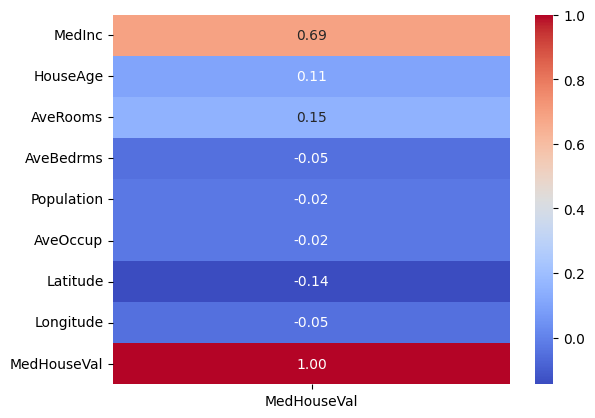

In [44]:
# plot the correlation heatmap for house value
num_corr=pd.concat([x1,y1],axis=1).corr()[["MedHouseVal"]]
sns.heatmap(num_corr,annot=True,cmap="coolwarm",fmt=".2f")


Text(0, 0.5, 'MedHouseVal')

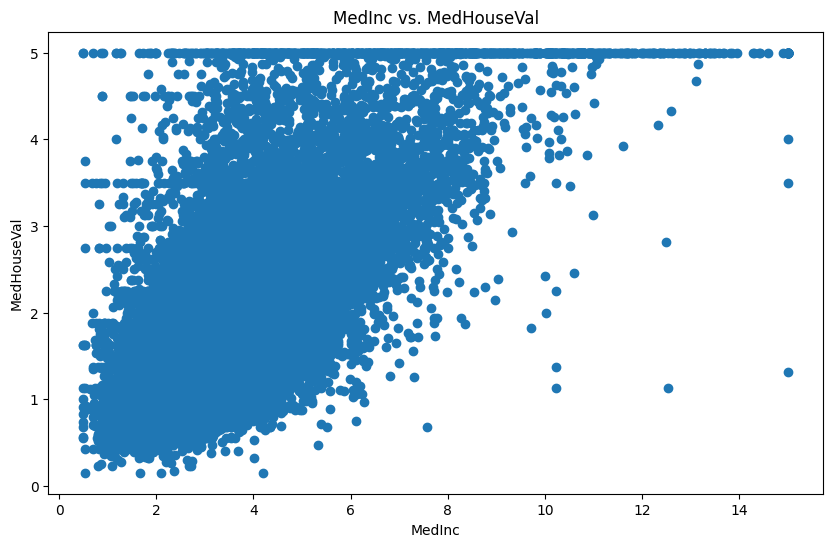

In [45]:
# create scatter plot to visualize medinx vs medhouseVal
plt.figure(figsize=(10,6))
plt.scatter(x=x1["MedInc"],y=y1)
plt.title("MedInc vs. MedHouseVal")
plt.xlabel("MedInc")
plt.ylabel("MedHouseVal")


In [46]:
description_two=pd.concat([x1["MedInc"].describe(),y1.describe()],axis=1)
print(description_two)
description_all=pd.concat([x1.describe(),y1.describe()],axis=1)
print(description_all)


             MedInc   MedHouseVal
count  20640.000000  20640.000000
mean       3.870671      2.068558
std        1.899822      1.153956
min        0.499900      0.149990
25%        2.563400      1.196000
50%        3.534800      1.797000
75%        4.743250      2.647250
max       15.000100      5.000010
             MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
mean       3.870671     28.639486      5.429000      1.096675   1425.476744   
std        1.899822     12.585558      2.474173      0.473911   1132.462122   
min        0.499900      1.000000      0.846154      0.333333      3.000000   
25%        2.563400     18.000000      4.440716      1.006079    787.000000   
50%        3.534800     29.000000      5.229129      1.048780   1166.000000   
75%        4.743250     37.000000      6.052381      1.099526   1725.000000   
max       15.000100     52.000000    141.909091     34.066667 

In [47]:
# split data into train and test set then apply data normalization using standard scaler
x1["MedInc"].unique()
#### considered to add some feature based on the correlation
#"MedInc" will be the main feature ,others are covered in the session: discussion points
x_train,x_test,y_train,y_test=train_test_split(x1[["MedInc","Latitude","HouseAge","AveRooms","AveBedrms","Longitude"]],y1,test_size=0.2,random_state=42)


# data normalization using standard scaler
scaler=StandardScaler()
# Fit the scaler only on the training data
x_train_scaled = scaler.fit_transform(x_train)

# Transform the test data using the same scaler
x_test_scaled = scaler.transform(x_test)
x_test_scaled

array([[-1.15508475,  0.1951    , -0.28632369, -0.52068576, -0.17174603,
         0.28534728],
       [-0.70865905, -0.23549054,  0.11043502, -0.16581537,  0.22347203,
         0.06097472],
       [-0.21040155,  1.00947776,  1.85617335, -0.61076476,  0.20589202,
        -1.42487026],
       ...,
       [ 2.80902421,  0.78014149, -0.28632369,  0.75501156, -0.34510886,
        -1.23041404],
       [-0.57542978,  0.52740357,  0.58654547, -0.06124296, -0.26214684,
        -0.08860699],
       [-0.17259111, -0.66608108, -0.92113763, -0.6058703 , -0.14589658,
         0.60445493]], shape=(4128, 6))

### Batch Gradient Descent

In [48]:
def batch_gradient_descent(x,y,learning_rate=0.001,iterations=1000):
    # avoid error when there is only one feature
    if x.ndim == 1:
        x= x.reshape(-1, 1)
    n, d = x.shape
    d+=1
    # add a bias term ,let it be the constant 1
    x = np.c_[x, np.ones((n, 1))]
    # initialize the value for weights and bias term
    params=np.zeros(d)
    errors=[]

    for i in range(iterations):
        y_pred = np.dot(x,params)  # last params will be the bias term
        error = y - y_pred  

        # Compute gradients
        gradients = np.dot(x.T, error) / n    

        # Update parameters
        params+= learning_rate * gradients 

        # Compute and store Mean Squared Error (MSE)
        mse = np.mean(error ** 2)
        errors.append(mse)

    return params, errors



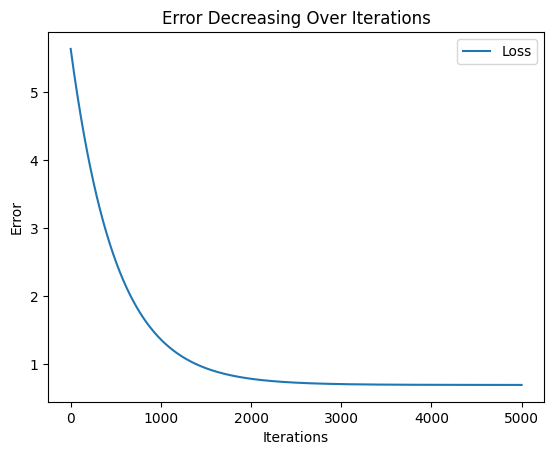

[0.79315263 2.05802115]


In [49]:
# check the performance

weights,performance_batch = batch_gradient_descent(x_train_scaled[:, 0],y_train,iterations=5000) 
#x_train_scaled[:, 0] this ensure the only feature is income level

# Plot loss over iterations
plt.plot(range(len(performance_batch)), performance_batch, label="Loss")
plt.xlabel("Iterations")
plt.ylabel("Error")
plt.title("Error Decreasing Over Iterations")
plt.legend()
plt.show()
print (weights)

### Stochastic Gradient Descent


In [50]:
def stochastic_gradient_descent(x,y,learning_rate=0.001,iterations=1):
    if x.ndim == 1:
        x= x.reshape(-1, 1)
    n, d = x.shape
    d+=1
    x = np.c_[x, np.ones((n, 1))]
    params=np.zeros(d)
    # the above is same logic as batch gradient descent
    # convert the varaible to numpy array
    x, y = np.array(x), np.array(y)
    errors=[]
    np.random.seed(42)
    for j in range(iterations):
        total_errors=0 # compute the error for each epoch
        indices = np.random.permutation(n)  # Shuffle indices
        x_shuffled, y_shuffled = x[indices], y[indices]  # rearange the variable to help generalization
        for i in range(n): # update the gradient for each sample
            # only update based on one sample instead of the whole dataset
            y_pred = np.dot(x_shuffled[i], params)
            error = y_shuffled[i]  - y_pred
            
            gradients = -x_shuffled[i]*(error)  # Gradient for weights

            # Update parameters
            params -= learning_rate * gradients
            total_errors += (y_shuffled[i]-y_pred)**2 # add the error to total error for each sample update

        errors.append(total_errors/n)

    return params, errors

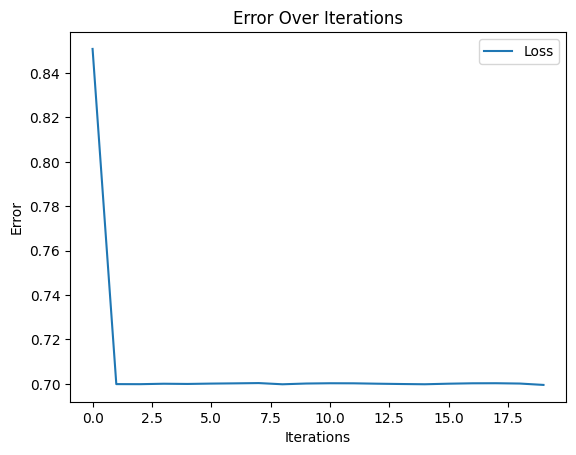

[0.85127083 2.09913956]


In [51]:
# check the performance

weight_stochastic,performance_stochastic = stochastic_gradient_descent(x_train_scaled[:, 0],y_train,iterations=20)

# Plot loss over iterations
plt.plot(range(len(performance_stochastic)), performance_stochastic, label="Loss")
plt.xlabel("Iterations")
plt.ylabel("Error")
plt.title("Error Over Iterations")
plt.legend()
plt.show()
print (weight_stochastic)

In [52]:
# check their performance on test set
prediction_batch=x_test_scaled[:, 0]*weights[0]+weights[-1]
error_batch=mean_squared_error(y_test,prediction_batch)
prediction_stochastic=x_test_scaled[:, 0]*weight_stochastic[0]+weights[-1]
error_stochastic=mean_squared_error(y_test,prediction_stochastic)
print(f"prediction Error using batch gradient descent: {error_batch}")
print(f"prediction Error using stochastic gradient descent: {error_stochastic}")


prediction Error using batch gradient descent: 0.7093081441390571
prediction Error using stochastic gradient descent: 0.7135855724662784


In [53]:
# make prediction for median income=8
prediction_batch8=8*weights[0]+weights[-1]
prediction_stochastic8=8*weight_stochastic[0]+weights[-1]
print(f"prediction using batch gradient descent: {prediction_batch8}")
print(f"prediction using stochastic gradient descent: {prediction_stochastic8}")

prediction using batch gradient descent: 8.403242150288927
prediction using stochastic gradient descent: 8.868187814659436


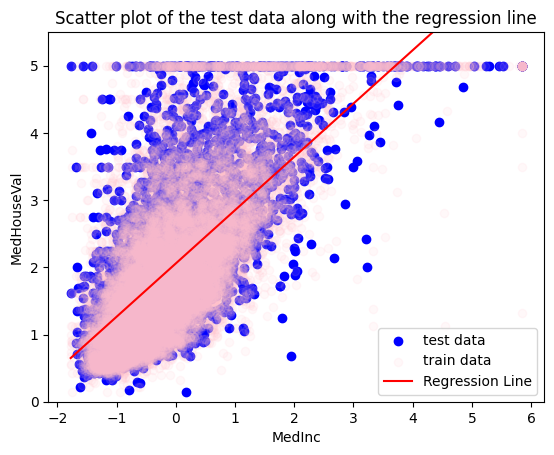

In [54]:
# Visualize the result
x_line = np.linspace(min(x_train_scaled[:, 0]), max(x_train_scaled[:, 0]), 100) # this x_line is generated by ai
y_line =x_line*weights[0]+weights[-1]
plt.scatter(x_test_scaled[:, 0],y_test,color="blue",label="test data")
plt.scatter(x_train_scaled[:, 0],y_train,color="pink",alpha=0.1,label="train data")
plt.title("Scatter plot of the test data along with the regression line")
plt.plot(x_line, y_line, color='red', label="Regression Line")
plt.xlabel("MedInc")
plt.ylabel("MedHouseVal")
plt.ylim(0, 5.5) # use 5.5 to ensure the data point lying on the cap can be visualize 
plt.legend()


In [55]:
# increase number of feature that might improve the model
features=["MedInc","HouseAge","AveRooms","Latitude"] # these are the feature that cinsdered to add as their correlation with target variable is higer than the others
weights_Multiple,performance_Multiple = batch_gradient_descent(x_train_scaled,y_train,iterations=5000)
# see its performance on test set
prediction_Multiple=x_test_scaled@weights_Multiple[0:-1]+weights_Multiple[-1]
error_Multiple=mean_squared_error(y_test,prediction_Multiple)

print(f"prediction Error using batch gradient descent: {error_Multiple}")

prediction Error using batch gradient descent: 0.597877803555519


In [56]:
# print and check the weights
#["MedInc","Latitude","HouseAge","AveRooms","AveBedrms","Longitude"]
weights_Multiple[0:-1]

array([ 0.78984088, -0.32361526,  0.18998452, -0.02459157,  0.03418175,
       -0.27930529])

from the above result,it indicated that income level has the most significant impact to the house price, while the geometric reason(latitude and longiude) impact 

# Support Vector Machines

In [57]:
# load the dataset

PATH = "UCI HAR Dataset/"
features_path = PATH + "features.txt"
activity_labels_path = PATH + "activity_labels.txt"
X_train_path = PATH + "train/X_train.txt"
y_train_path = PATH + "train/y_train.txt"
X_test_path = PATH + "test/X_test.txt"
y_test_path = PATH + "test/y_test.txt"

# Load feature names
features_df = pd.read_csv(features_path, sep="\\s+", header=None, names=["idx", "feature"])
feature_names = features_df["feature"].tolist()

seen = {}
unique_feature_names = []
for x in feature_names:
    if x not in seen:
        seen[x] = 0
        unique_feature_names.append(x)
    else:
        seen[x] += 1
        unique_feature_names.append(f"{x}_{seen[x]}")


# Load activity labels (mapping IDs 1-6 to string names)
activity_labels_df = pd.read_csv(activity_labels_path, sep="\\s+", header=None, names=["id", "activity"])
activity_map = dict(zip(activity_labels_df.id, activity_labels_df.activity))

# Load train/test sets
X_train = pd.read_csv(X_train_path, sep="\\s+", header=None, names=unique_feature_names)
Y_train = pd.read_csv(y_train_path, sep="\\s+", header=None, names=["Activity"])
X_test = pd.read_csv(X_test_path, sep="\\s+", header=None, names=unique_feature_names)
Y_test = pd.read_csv(y_test_path, sep="\\s+", header=None, names=["Activity"])

# Map the activity IDs to their names
Y_train["Activity"] = Y_train["Activity"].map(activity_map)
Y_test["Activity"] = Y_test["Activity"].map(activity_map)

# --- 2. CONVERT MULTI-CLASS TO BINARY ---
def to_binary_label(activity):
    if activity in ["WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS"]:
        return 1 # Active
    else:
        return 0 # Inactive
Y_train["Binary"] = Y_train["Activity"].apply(to_binary_label)
Y_test["Binary"] = Y_test["Activity"].apply(to_binary_label)


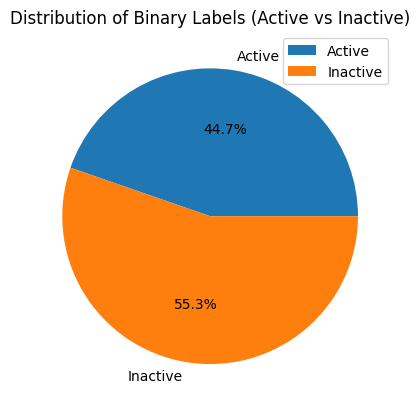

In [58]:
# check if the binary label is imbalanced
ratio=Y_train["Binary"].sum()/len(Y_train)
labels = ["Active", "Inactive"]
sizes = [ratio, 1 - ratio]

# Create pie chart

plt.pie(sizes, labels=labels, autopct="%1.1f%%")
plt.title('Distribution of Binary Labels (Active vs Inactive)')
plt.legend()
plt.show()

44.68% of class 1 suggest slight imbalance ,but not impactful.

In [59]:
subject_train = pd.read_csv("UCI HAR Dataset/train/subject_train.txt", header=None, names=["Subject"])
subject_test = pd.read_csv("UCI HAR Dataset/test/subject_test.txt", header=None, names=["Subject"])
# check the common subject
print(set(subject_train["Subject"]) & set(subject_test["Subject"]))

set()


since this is an empty set,this result ensure there is no common subject in both trian and test set

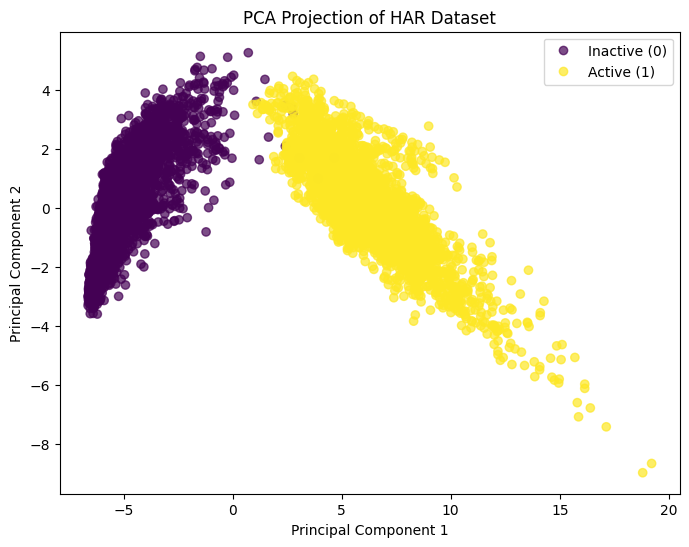

In [60]:
# apply pca visualization to check if there is a pattern
pca2=PCA(n_components=2)
x_pca2=pca2.fit_transform(X_train)
plt.figure(figsize=(8,6))
scatter = plt.scatter(x_pca2[:, 0], x_pca2[:, 1],  c=Y_train["Binary"], alpha=0.7)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Projection of HAR Dataset")
plt.legend(handles=scatter.legend_elements()[0], labels=['Inactive (0)', 'Active (1)'])
plt.show()

### Train baseline SVM models with different kernels (linear, polynomial, RBF)

In [61]:
### 30 principal components
kernel=["linear","poly","rbf"]
# create a disctionary to store different kernel
pipelines={}
for i in kernel:
    pipelines[i] = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=30)),
        ('svc', SVC(kernel=i))
    ])


comparison={}
for kernel, pipeline in pipelines.items():
    # Fit the pipeline
    pipeline.fit(X_train, Y_train["Binary"])
    
    # Predict on test set
    y_pred = pipeline.predict(X_test)
    
    # Calculate metrics
    comparison[kernel] = {
        'accuracy': accuracy_score(Y_test["Binary"], y_pred),
        'f1_score': f1_score(Y_test["Binary"], y_pred)
    }

# Create and print DataFrame
results_df = pd.DataFrame.from_dict(comparison, orient="index")
print(results_df)

        accuracy  f1_score
linear  0.999661  0.999640
poly    0.998303  0.998201
rbf     0.999661  0.999640


In [62]:
### 50 principal components
# same logic as above just change the pricipal compoents from 30 to 50
kernel=["linear","poly","rbf"]
pipelines={}
for i in kernel:
    pipelines[i] = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=50)),
        ('svc', SVC(kernel=i))
    ])


comparison={}
for kernel, pipeline in pipelines.items():
    # Fit the pipeline
    pipeline.fit(X_train, Y_train["Binary"])
    
    # Predict on test set
    y_pred = pipeline.predict(X_test)
    
    # Calculate metrics
    comparison[kernel] = {
        'accuracy': accuracy_score(Y_test["Binary"], y_pred),
        'f1_score': f1_score(Y_test["Binary"], y_pred)
    }

# Create and print DataFrame
results_df = pd.DataFrame.from_dict(comparison, orient="index")
print(results_df)

        accuracy  f1_score
linear  1.000000  1.000000
poly    0.998303  0.998201
rbf     0.999661  0.999640


In [63]:
# perform the cross validation on baseline model 
# this is applied pca with 50 principal compoenents
# Dictionary to store results
cv_comparison = {}

for kernel, pipeline in pipelines.items():
    # Perform 5-fold cross-validation
    cv_scores = cross_val_score(pipeline, X_train, Y_train["Binary"], cv=5, scoring="accuracy")
    
    # Fit the pipeline and predict on test set
    pipeline.fit(X_train, Y_train["Binary"])
    y_pred = pipeline.predict(X_test)
    
    cv_comparison[kernel] = {
        "mean_accuracy": cv_scores.mean(),
        "test_accuracy": accuracy_score(Y_test["Binary"], y_pred),
        "test_f1_score": f1_score(Y_test["Binary"], y_pred)
    }


print(pd.DataFrame.from_dict(cv_comparison, orient="index"))


        mean_accuracy  test_accuracy  test_f1_score
linear       0.999456       1.000000       1.000000
poly         0.998912       0.998303       0.998201
rbf          0.999048       0.999661       0.999640


### perform the randomized grid search

In [64]:
# Define the pipeline
pipe = Pipeline([
    ('scaler', StandardScaler()),  # Fixing quote
    ('pca', PCA(n_components=50)), # Uncomment if PCA is needed
    ('svc', SVC())
])

# Define the hyperparameter grid
param_grid = [
    {  # Linear Kernel
        'svc__kernel': ['linear'],
        'svc__C': [0.1, 1, 10, 100]
    },
    {  # Polynomial Kernel
        'svc__kernel': ['poly'],
        'svc__C': [0.1, 1],
        'svc__degree': [2, 3],
        'svc__gamma': [0.001, 0.01, 0.1]
    },
    {  # RBF Kernel
        'svc__kernel': ['rbf'],
        'svc__C': [0.1, 1, 10],
        'svc__gamma': [0.001, 0.01, 0.1]
    }
]

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring='accuracy',  # Fixing quote
    cv=3,  # 3-fold CV to save time
    n_jobs=-1,  # Use all available cores
    verbose=1
)

# Train GridSearchCV
grid_search.fit(X_train, Y_train["Binary"])

# Display Best Parameters and Best Score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)


Fitting 3 folds for each of 25 candidates, totalling 75 fits
Best parameters: {'svc__C': 0.1, 'svc__degree': 3, 'svc__gamma': 0.01, 'svc__kernel': 'poly'}
Best cross-validation accuracy: 0.9993200054399565


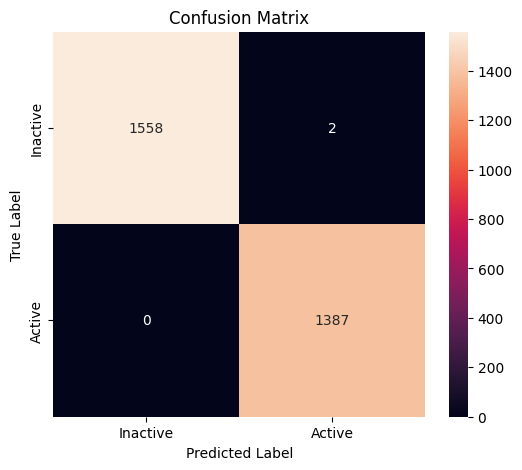

In [65]:
# plot the confusion matrix for the best model from grid search
best_model = grid_search.best_estimator_

# Predict on test data
y_pred = best_model.predict(X_test)

# Compute and print metrics
confusion_matrix = confusion_matrix(Y_test["Binary"], y_pred)
# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix, annot=True, fmt="d", xticklabels=["Inactive", "Active"], yticklabels=["Inactive", "Active"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [66]:
# check the feature of those two misclassified sample
# Extract misclassified samples
misclassified_samples = X_test[(Y_test["Binary"] == 0) & (y_pred == 1)]

# Print the misclassified samples
print(pd.DataFrame(misclassified_samples, columns=X_test.columns))  


      tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  \
791            0.044667          -0.100836           0.112583   
2392           0.205043          -0.084073          -0.144331   

      tBodyAcc-std()-X  tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  \
791          -0.659240         -0.151193          0.242568         -0.654091   
2392         -0.881596         -0.814724         -0.522728         -0.895191   

      tBodyAcc-mad()-Y  tBodyAcc-mad()-Z  tBodyAcc-max()-X  ...  \
791          -0.052666          0.427958         -0.830019  ...   
2392         -0.821032         -0.544331         -0.809820  ...   

      fBodyBodyGyroJerkMag-meanFreq()  fBodyBodyGyroJerkMag-skewness()  \
791                         -0.065422                        -0.096119   
2392                         0.151721                        -0.562968   

      fBodyBodyGyroJerkMag-kurtosis()  angle(tBodyAccMean,gravity)  \
791                         -0.362858                     0.151458  